# Score Predictions

In the context of football modeling, the outcomes are correlated and ordered. In a traditional classification task, each class is independent. Yet for some tasks, the classes are correlated, such that one is more similar to others. For football, the outcome of the home team winning is more similar to a draw than to an away win. Ranked Probability Score is a score function for probabilistic distributions. It accounts for the similarity of outcomes when measuring probabilistic models by measuring the fit of the cumulative distributions of the prediction and the outcomes using the formula:

$$RPS = \frac{1}{n-1} \sum_{i=1}^n (\sum_{j=1}^i p_j - \sum_{j=1}^i r_j)^2 $$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

from ranked_probability_score import ranked_probability_score, match_outcome
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

In [4]:
# Get fixture outcomes
outcomes = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcomes = (
    outcomes
    .loc[(outcomes['league_id'] == 2411) | (outcomes['league_id'] == 2412)]
    .dropna()
    )

## Baselines

In [5]:
from baselines import Baselines

# Get GW dates
fixtures = (
    pd.read_csv("../../data/fpl_official/vaastav/data/2021-22/fixtures.csv")
    .loc[:, ['event', 'kickoff_time']])
fixtures["kickoff_time"] = pd.to_datetime(fixtures["kickoff_time"]).dt.date

# Get only EPL games from the current season
season_games = (
    outcomes
    .loc[outcomes['league_id'] == 2411]
    .loc[outcomes['season'] == 2021]
    )
season_games["kickoff_time"] = pd.to_datetime(season_games["date"]).dt.date

# Merge outcomes with GW dates
season_games = (
    pd.merge(
        season_games,
        fixtures,
        left_on='kickoff_time',
        right_on='kickoff_time')
    .drop_duplicates()
    )

baselines = Baselines(season_games)

# Add the home team and away team index for running inference
idx = (
    pd.DataFrame()
    .assign(team=baselines.teams)
    .assign(team_index=np.arange(baselines.league_size)))

season_games = (
    pd.merge(season_games, idx, left_on="team1", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .drop_duplicates()
    .merge(idx, left_on="team2", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("date")
)

### Uniform Odds

In [6]:
predictions_uniform = baselines.evaluate(season_games, 'uniform')
f"{(np.mean(predictions_uniform.rps)*100):.2f}"

'23.92'

### Home bias

In [7]:
predictions_home = baselines.evaluate(season_games, 'home')
f"{(np.mean(predictions_home.rps)*100):.2f}"

'45.53'

### Draw bias

In [8]:
predictions_draw = baselines.evaluate(season_games, 'draw')
f"{(np.mean(predictions_draw.rps)*100):.2f}"

'38.42'

### Away bias

In [9]:
predictions_away = baselines.evaluate(season_games, 'away')
f"{(np.mean(predictions_away.rps)*100):.2f}"

'54.47'

### Random odds

In [10]:
predictions_random = baselines.evaluate(season_games, 'random')
f"{(np.mean(predictions_random.rps)*100):.2f}"

'27.08'

### Bookies Odds

In [11]:
predictions_bookies = baselines.evaluate(season_games, 'bookies', '../../')
f"{(np.mean(predictions_bookies.rps)*100):.2f}"

'18.90'

### Bookies Favorite

In [12]:
predictions_favorite = baselines.evaluate(season_games, 'favorite', '../../')
f"{(np.mean(predictions_favorite.rps)*100):.2f}"

'61.32'

### SPI

In [13]:
from spi import SPI

spi = SPI(outcomes.loc[outcomes.season == 2021])

predictions_spi = spi.evaluate()
predictions_spi = (
    pd.merge(
        (
            pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv")
            .loc[:, ['team1', 'team2', 'event']]),
        predictions_spi,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2']
    )
)
f"{(np.mean(predictions_spi.rps)*100):.2f}"

'19.20'

## Modeling Outcomes

### Thurstone Mosteller

In [14]:
predictions_tm = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_tm["winner"] = match_outcome(predictions_tm)
predictions_tm["rps"] = (
    predictions_tm.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_tm['rps'])*100):.2f}"

'20.94'

### Bradley Terry

In [15]:
predictions_bt = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bradley_terry.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bt["winner"] = match_outcome(predictions_bt)
predictions_bt["rps"] = (
    predictions_bt.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bt['rps'])*100):.2f}"

'21.08'

### Elo Rating

In [16]:
predictions_elo = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/elo.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_elo["winner"] = match_outcome(predictions_elo)
predictions_elo["rps"] = (
    predictions_elo.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_elo['rps'])*100):.2f}"

'19.62'

## Modeling Goals Scored

### Independent Poisson

In [17]:
predictions_ip = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/independent_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_ip["winner"] = match_outcome(predictions_ip)
predictions_ip["rps"] = (
    predictions_ip.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_ip['rps'])*100):.2f}"

'19.30'

### Bivariate Poisson

In [18]:
predictions_bp = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bivariate_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bp["winner"] = match_outcome(predictions_bp)
predictions_bp["rps"] = (
    predictions_bp.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bp['rps'])*100):.2f}"

'19.27'

### Dixon Coles

In [19]:
predictions_dc = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_dc["winner"] = match_outcome(predictions_dc)
predictions_dc["rps"] = (
    predictions_dc.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_dc['rps'])*100):.2f}"

'19.27'

### Bayesian

In [20]:
predictions_bayesian = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bayesian.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bayesian["winner"] = match_outcome(predictions_bayesian)
predictions_bayesian["rps"] = (
    predictions_bayesian.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bayesian['rps'])*100):.2f}"

'19.43'

# Comparison

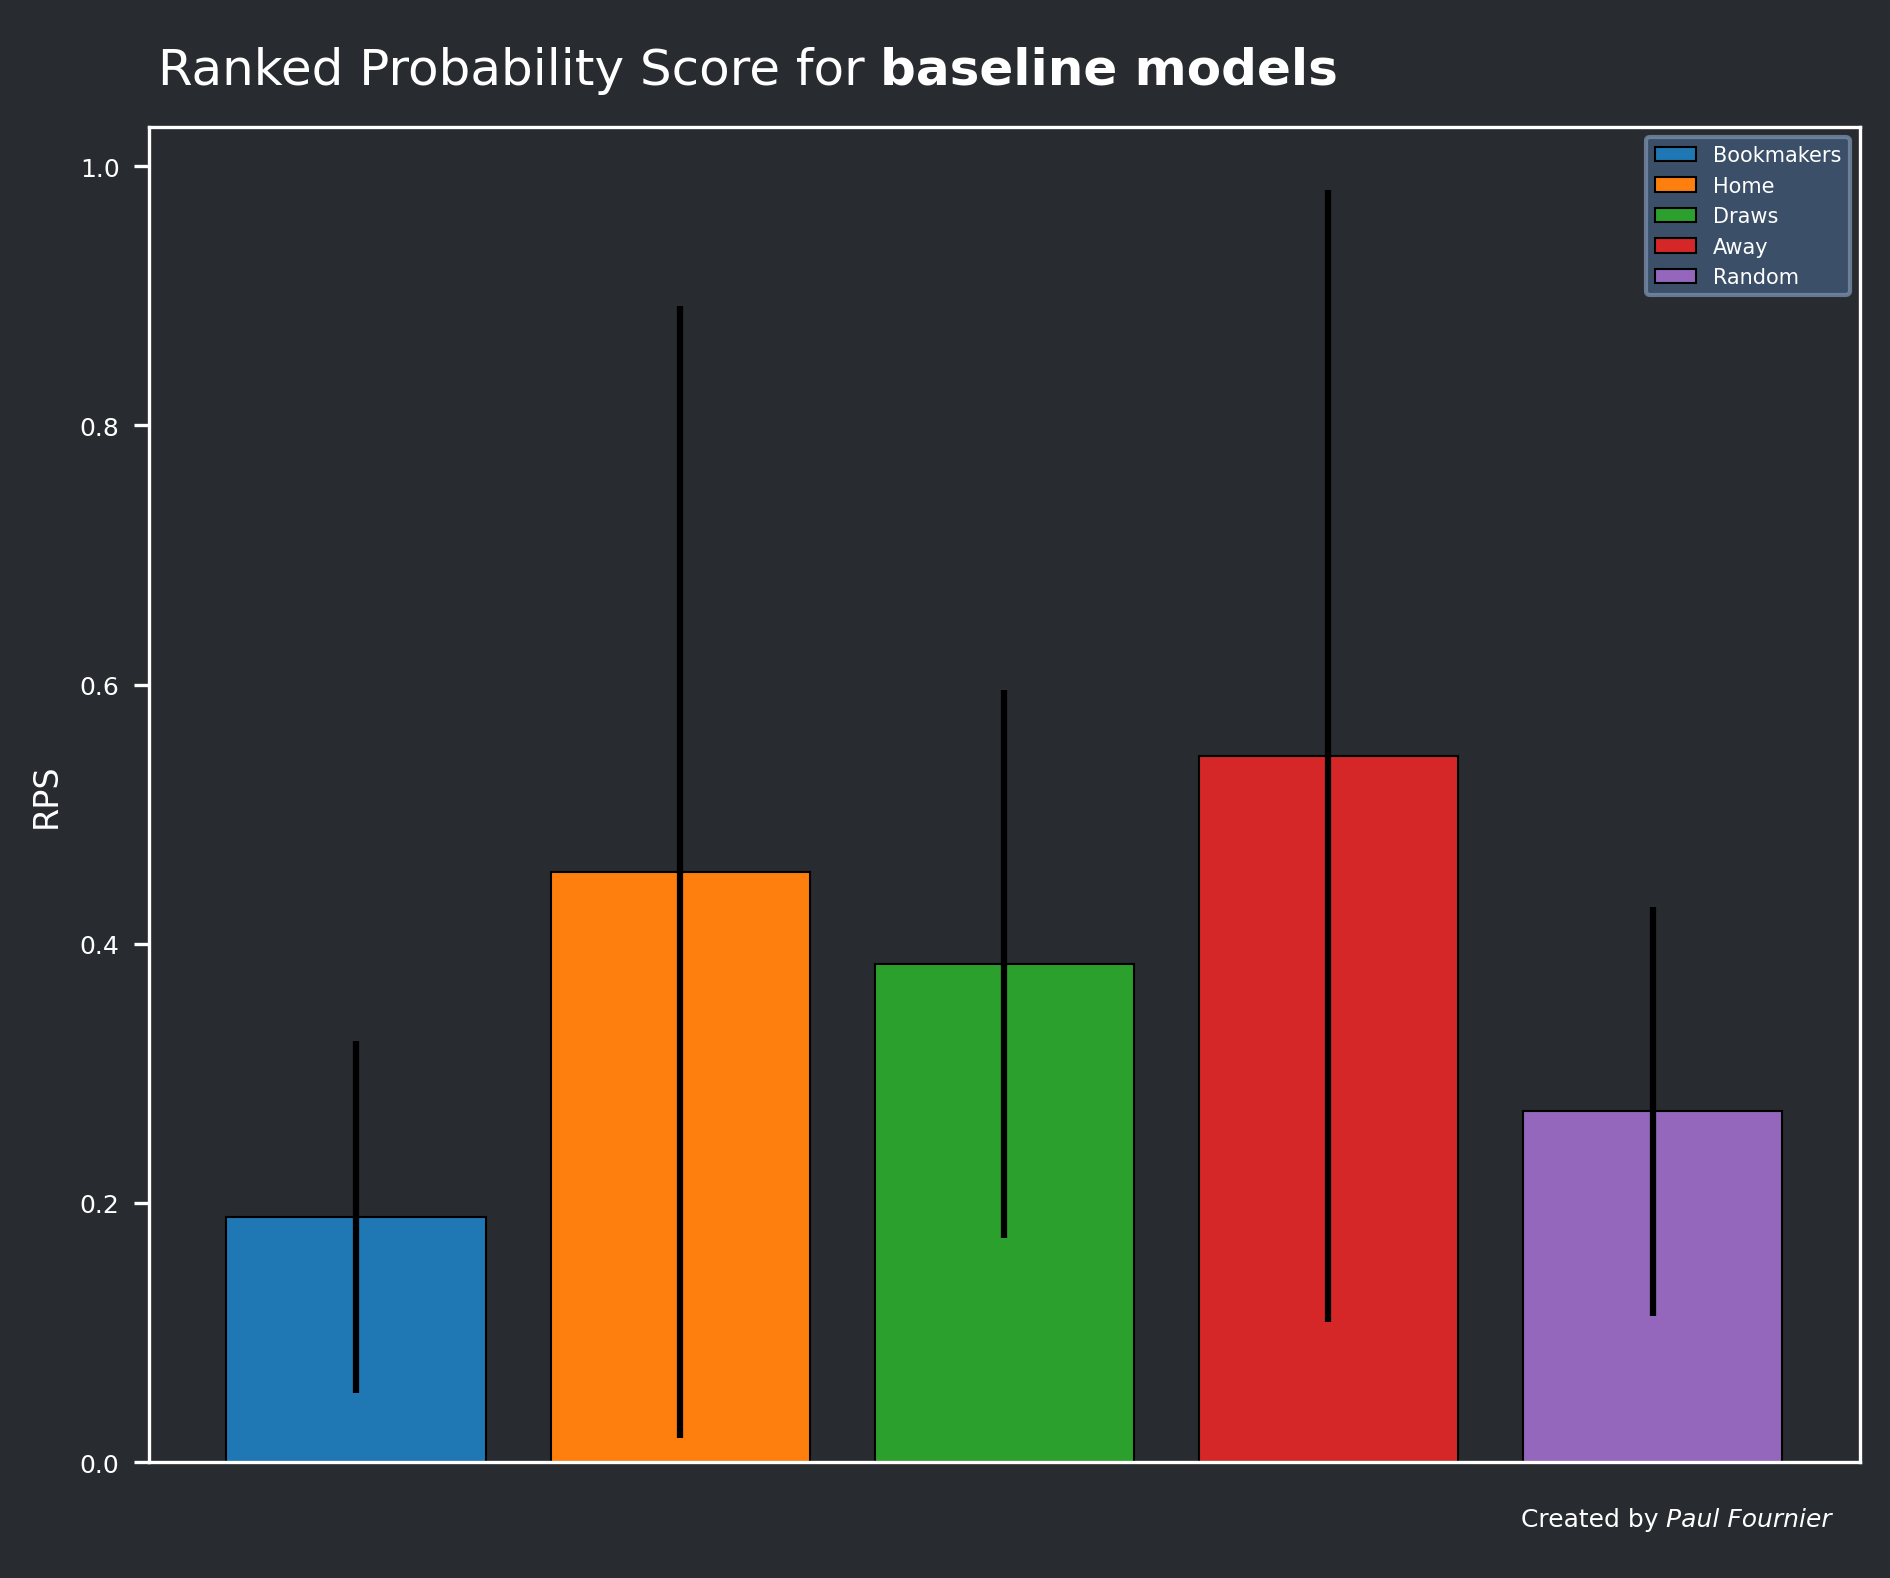

In [21]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.bar(
    [0], predictions_bookies['rps'].mean(),
    yerr = predictions_bookies['rps'].std(),
    label='Bookmakers',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [1], predictions_home['rps'].mean(),
    yerr = predictions_home['rps'].std(),
    label='Home',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [2], predictions_draw['rps'].mean(),
    yerr = predictions_draw['rps'].std(),
    label='Draws',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [3], predictions_away['rps'].mean(),
    yerr = predictions_away['rps'].std(),
    label='Away',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [4], predictions_random['rps'].mean(),
    yerr = predictions_random['rps'].std(),
    label='Random',
    edgecolor='black', linewidth=0.5)

ax.set_ylabel('RPS' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 5}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

ax.set_xticks([], minor=False)

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for <baseline models>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.01,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

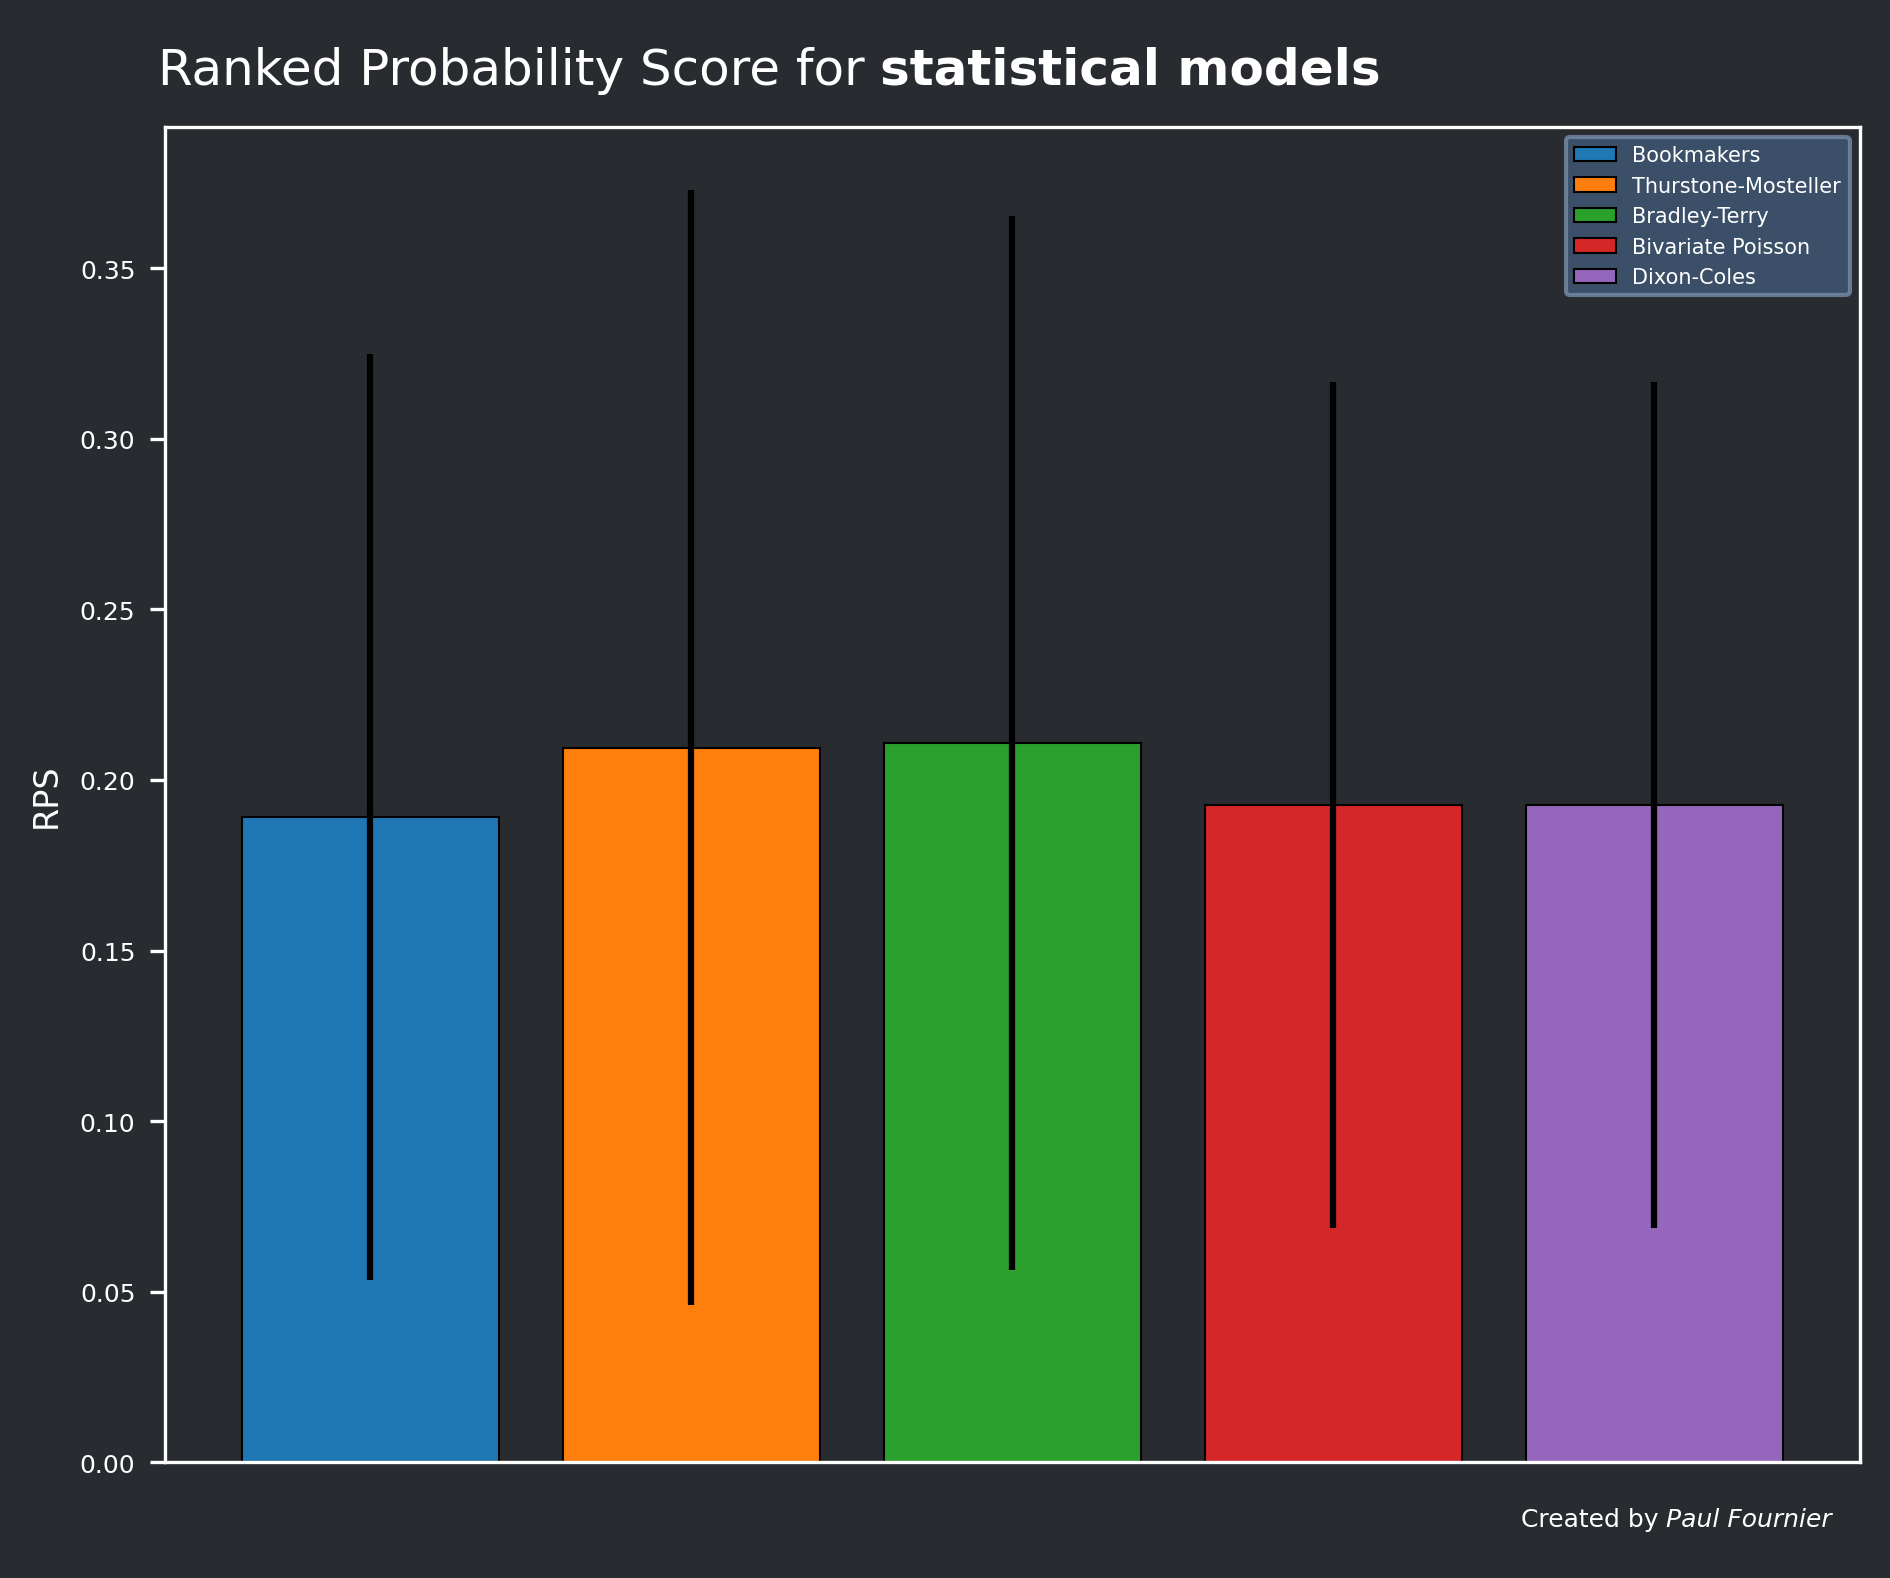

In [22]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.bar(
    [-1], predictions_bookies['rps'].mean(),
    yerr = predictions_bookies['rps'].std(),
    label='Bookmakers',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [0], predictions_tm['rps'].mean(),
    yerr = predictions_tm['rps'].std(),
    label='Thurstone-Mosteller',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [1], predictions_bt['rps'].mean(),
    yerr = predictions_bt['rps'].std(),
    label='Bradley-Terry',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [2], predictions_bp['rps'].mean(),
    yerr = predictions_bp['rps'].std(),
    label='Bivariate Poisson',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [3], predictions_dc['rps'].mean(),
    yerr = predictions_dc['rps'].std(),
    label='Dixon-Coles',
    edgecolor='black', linewidth=0.5)

ax.set_ylabel('RPS' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 5}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

ax.set_xticks([], minor=False)

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for <statistical models>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.01,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

## Confusion Matrix

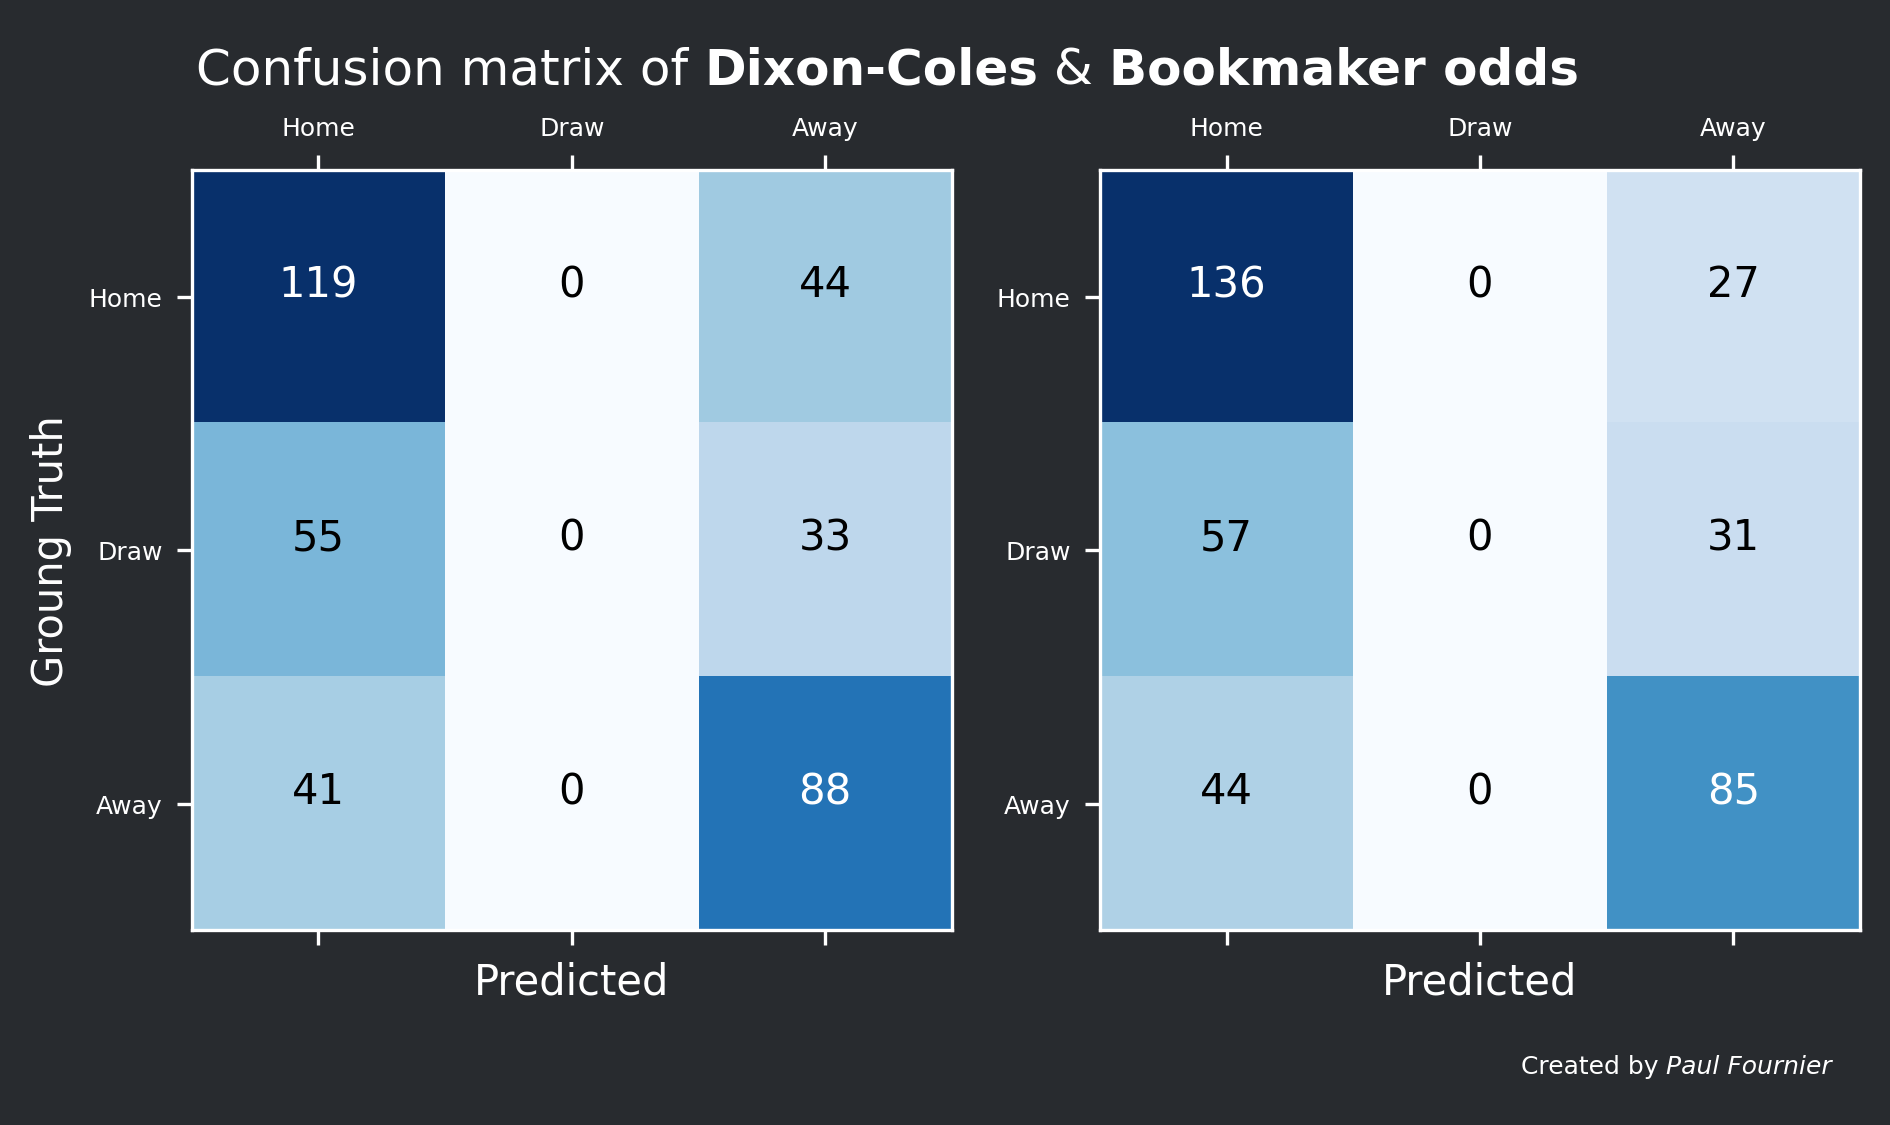

In [23]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(1, 2, tight_layout=True)
fig.set_facecolor(background)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)

cm = confusion_matrix(
    predictions_dc['winner'],
    np.argmax(
        predictions_dc[['home_win_p', 'draw_p', 'away_win_p']].values,
        axis=1
    ))

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cax = axs[0].matshow(cm, cmap=plt.get_cmap('Blues'))
# fig.colorbar(cax, axs[0])

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        axs[0].text(
            j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        axs[0].text(
            j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

cm = confusion_matrix(
    match_outcome(predictions_bookies),
    np.argmax(
        predictions_bookies[['home_win_p', 'draw_p', 'away_win_p']].values,
        axis=1
    ))

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cax = axs[1].matshow(cm, cmap=plt.get_cmap('Blues'))
# fig.colorbar(cax, axs[1])

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        axs[1].text(
            j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        axs[1].text(
            j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

axs[0].set_xticklabels([''] + ['Home', 'Draw', 'Away'])
axs[0].set_yticklabels([''] + ['Home', 'Draw', 'Away'])
axs[1].set_xticklabels([''] + ['Home', 'Draw', 'Away'])
axs[1].set_yticklabels([''] + ['Home', 'Draw', 'Away'])

axs[0].set_xlabel('Predicted')
axs[0].xaxis.label.set_color('w')
axs[0].set_ylabel('Groung Truth')
axs[0].yaxis.label.set_color('w')
axs[1].set_xlabel('Predicted')
axs[1].xaxis.label.set_color('w')

fig_text(
    x=0.11, y=.85,
    s="Confusion matrix of <Dixon-Coles> & <Bookmaker odds>",
    highlight_textprops=[
        {"fontweight": "bold"},
        {"fontweight": "bold"}],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.15,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

## Hyperparameter Search

In [24]:
predictions_tm_0 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_no_decay.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0["winner"] = match_outcome(predictions_tm_0)
predictions_tm_0["rps"] = (
    predictions_tm_0.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_00005 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_00005.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_00005["winner"] = match_outcome(predictions_tm_00005)
predictions_tm_00005["rps"] = (
    predictions_tm_00005.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_0001 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_0001.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0001["winner"] = match_outcome(predictions_tm_0001)
predictions_tm_0001["rps"] = (
    predictions_tm_0001.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_001 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_001.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_001["winner"] = match_outcome(predictions_tm_001)
predictions_tm_001["rps"] = (
    predictions_tm_001.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_0025 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_0025.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0025["winner"] = match_outcome(predictions_tm_0025)
predictions_tm_0025["rps"] = (
    predictions_tm_0025.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_005 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_005.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_005["winner"] = match_outcome(predictions_tm_005)
predictions_tm_005["rps"] = (
    predictions_tm_005.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

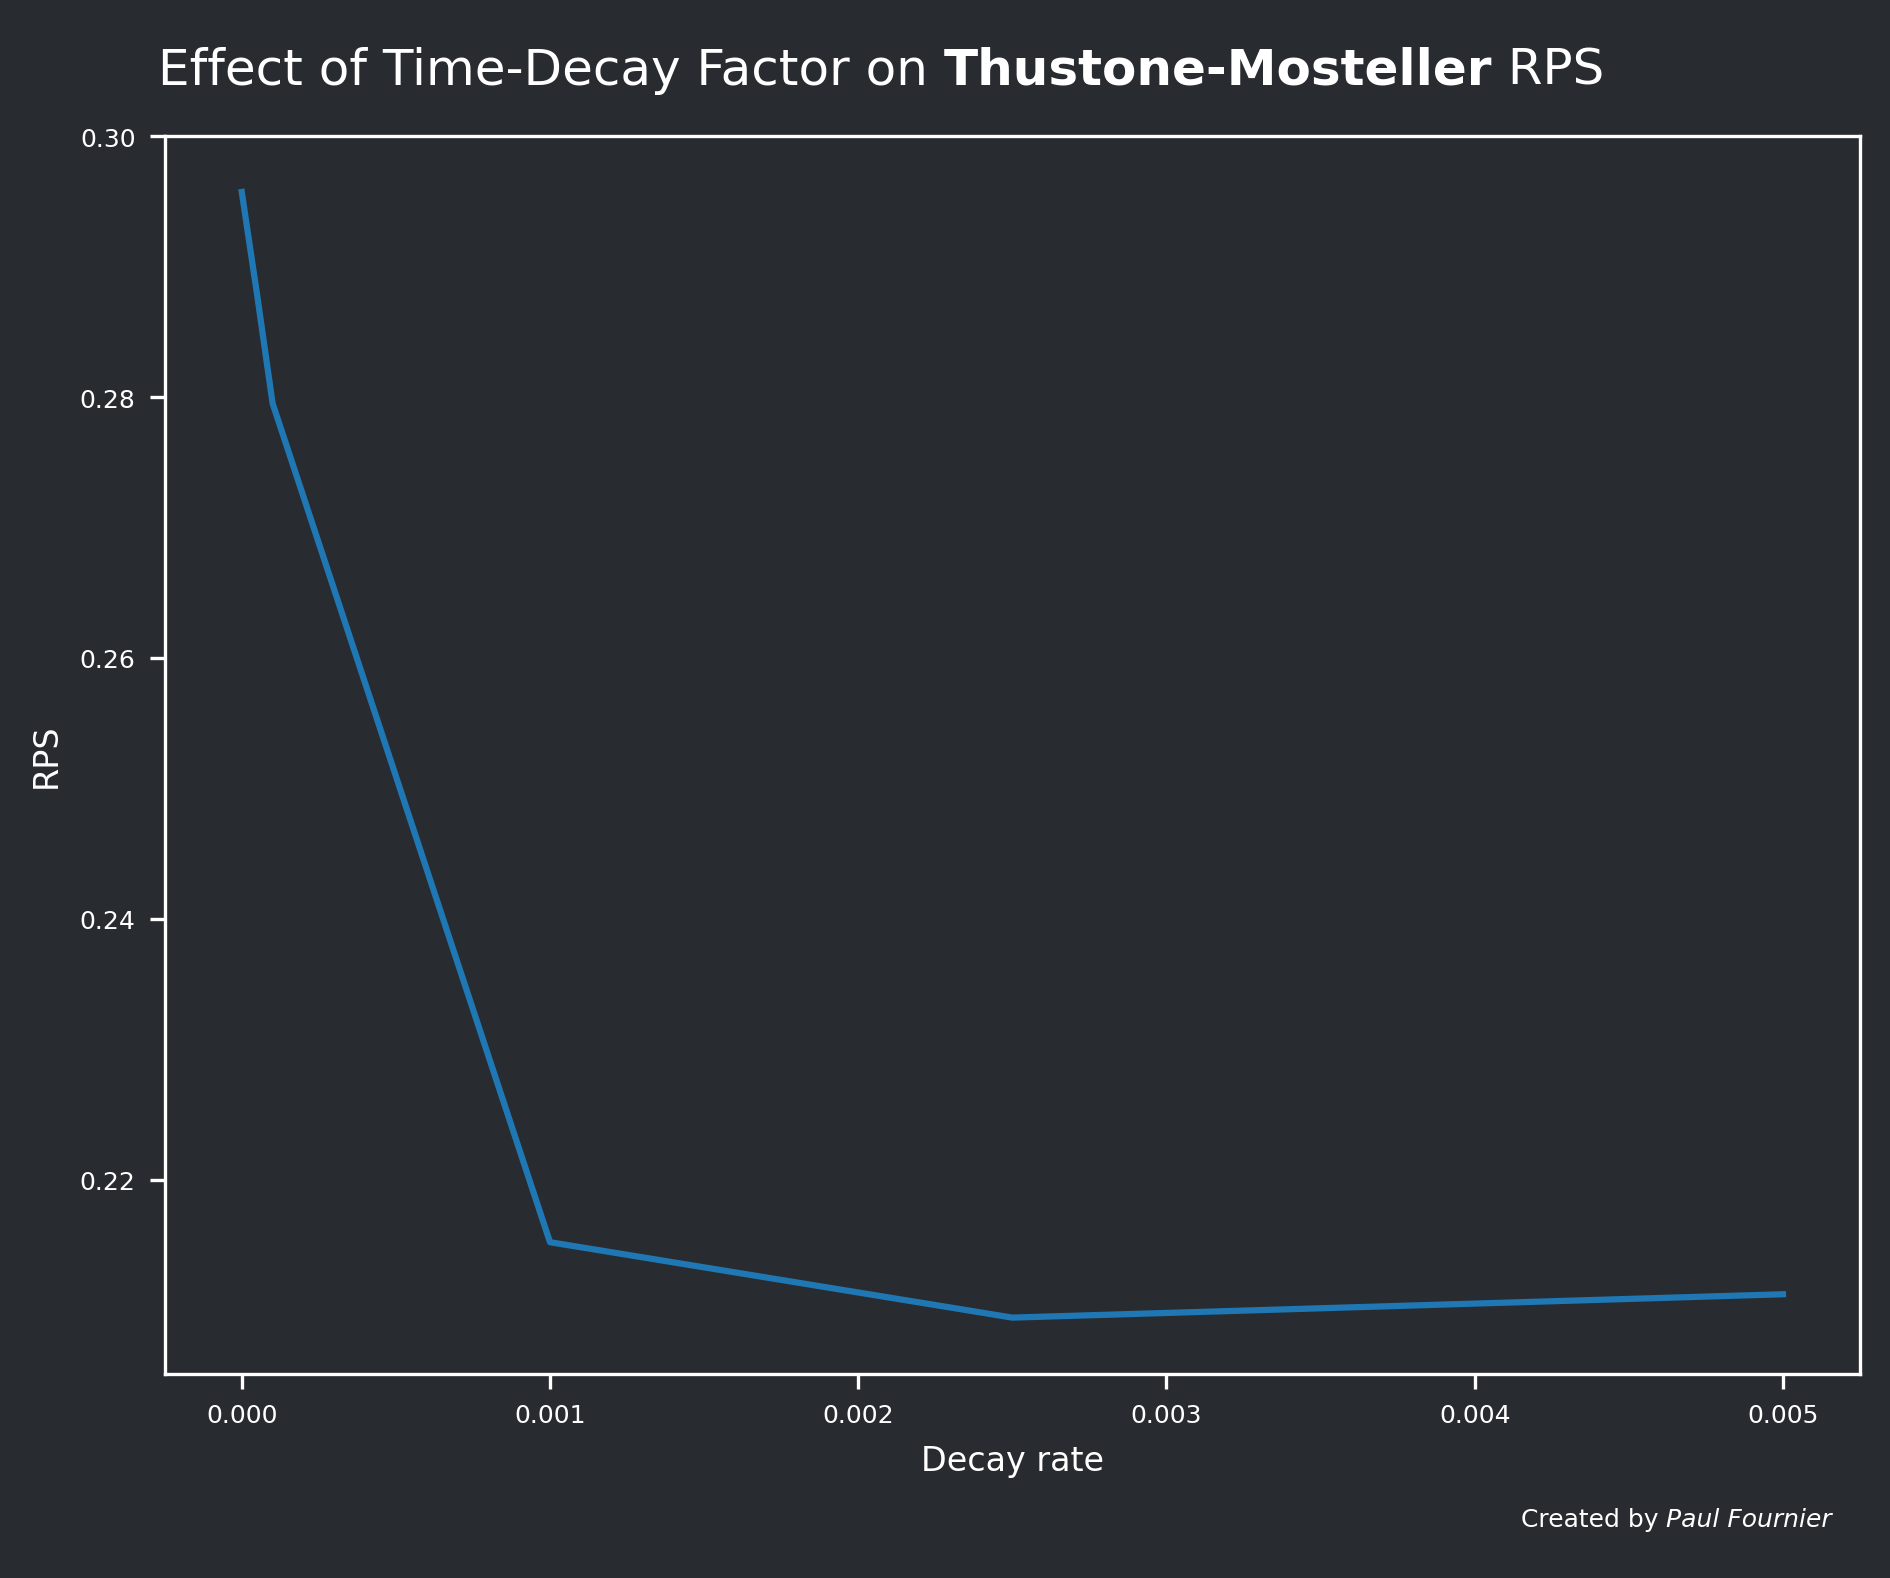

In [25]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    np.array([0, 0.00005, 0.0001, 0.001, 0.0025, 0.005]), 
    np.array([
        predictions_tm_0['rps'].mean(),
        predictions_tm_00005['rps'].mean(),
        predictions_tm_0001['rps'].mean(),
        predictions_tm_001['rps'].mean(),
        predictions_tm_0025['rps'].mean(),
        predictions_tm_005['rps'].mean()]))

ax.set_xlabel('Decay rate' , fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

fig_text(
    x=0.09, y=1.025,
    s="Effect of Time-Decay Factor on <Thustone-Mosteller> RPS",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.01,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()